# Training di una CNN per la classificazione di Alzheimer utilizzando immagini MRI del cervello

Punti chiave:

* Download del dataset da Kaggle
* Preprocessing del dataset
  *  Creazione di un dataset di validazione
  *  Applicare SMOTE al dataset di train
  *  Applicare RandAugment al dataset di train
* Definizione del modello utilizzando Keras
* Training e Validazione





In [1]:
!pip install --upgrade tensorflow pillow
!pip install keras
!pip install keras_cv
!pip install split-folders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 43.6 MB/s eta 0:00:00


## Import necessari

In [2]:
import zipfile
import os
from  os import path
from google.colab import files
import pathlib
import shutil
import splitfolders
import tempfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import img_to_array, load_img
from sklearn.utils import shuffle
from tensorflow import keras
import keras_cv
from imblearn.over_sampling import SMOTE
import cv2
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from collections import Counter

## Download del Dataset

Inserire il kaggle.json corrispondente al proprio account (è possibile scaricarlo una volta eseguito il login su kaggle).

In [3]:
files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                             title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
shreyanshverma27/online-sales-dataset-popular-marketplace-data  Online Sales Dataset - Popular Marketplace Data      7KB  2024-05-25 23:55:26           4734         91  1.0              
nuhmanpk/india-lok-sabha-election-results-2024                  Lok Sabha Election Results 2024 India               20KB  2024-06-05 05:49:01           1282         33  1.0              
hibrahimag1/top-1000-twitch-streamers-data-may-2024             Top 1000 Twitch Streamers Data                      39KB  2024-05-27 10:30:37           1139         27  1.0              
devarajv88/walmart-sales-datase

In [4]:
# Download del dataset
! kaggle datasets download tourist55/alzheimers-dataset-4-class-of-images

Dataset URL: https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images
License(s): ODbL-1.0
 97% 33.0M/34.1M [00:02<00:00, 19.1MB/s]
100% 34.1M/34.1M [00:02<00:00, 12.4MB/s]


In [5]:
# Estraiamo i file dallo zip e rimuoviamolo

zip_file_path = '/content/alzheimers-dataset-4-class-of-images.zip'
extract_to_path = '/content'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

! rm -f /content/alzheimers-dataset-4-class-of-images.zip

## Visualizzazione della distribuzione del dataset

<ipython-input-6-5507a92138ed>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(train_counts.keys(), rotation=45)
<ipython-input-6-5507a92138ed>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(test_counts.keys(), rotation=45)


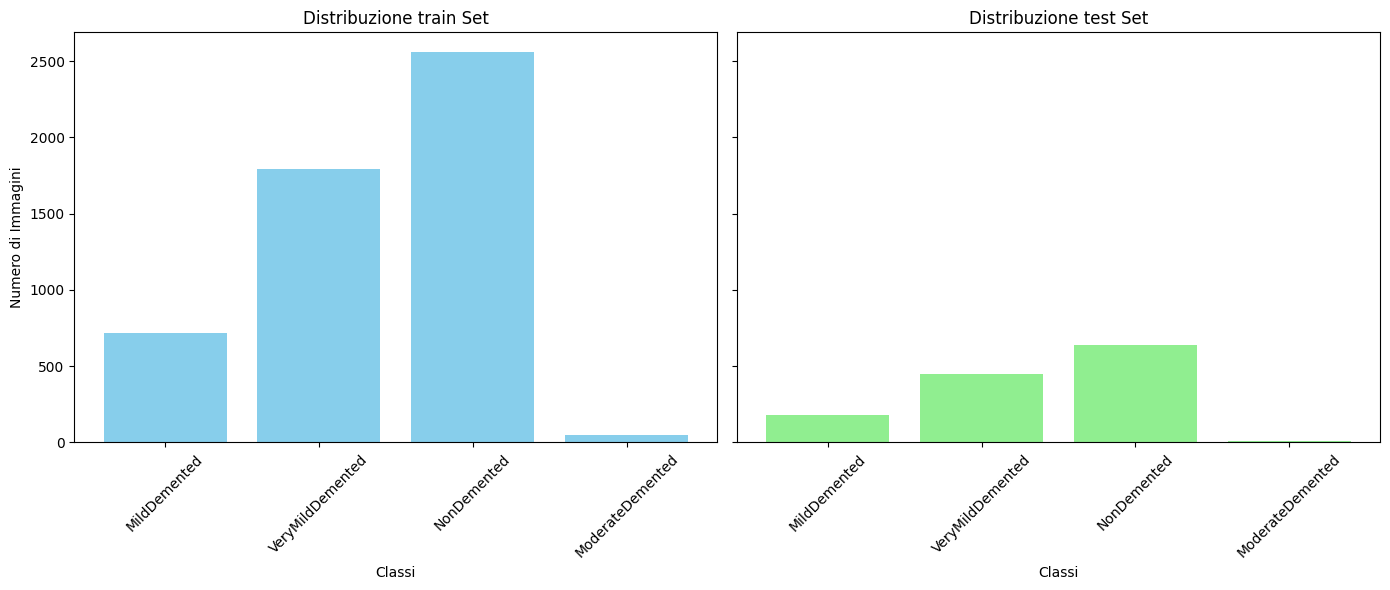

In [6]:
dataset_path = '/content/Alzheimer_s Dataset'
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')

# Funzione per contare il numero di file in ogni subdir
def count_images_in_dir(directory):
    count_dict = {}
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            count_dict[subdir] = len([f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))])
    return count_dict

train_counts = count_images_in_dir(train_path)
test_counts = count_images_in_dir(test_path)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

# Distribuzione del train set
axes[0].bar(train_counts.keys(), train_counts.values(), color='skyblue')
axes[0].set_title('Distribuzione train Set')
axes[0].set_xlabel('Classi')
axes[0].set_ylabel('Numero di Immagini')
axes[0].set_xticklabels(train_counts.keys(), rotation=45)

# Distribuzione del test set
axes[1].bar(test_counts.keys(), test_counts.values(), color='lightgreen')
axes[1].set_title('Distribuzione test Set')
axes[1].set_xlabel('Classi')
axes[1].set_xticklabels(test_counts.keys(), rotation=45)

plt.tight_layout()
plt.show()

## Generazione di un dataset di validazione

E' cruciale avere un dataset di validazione che ci permette di validare il modello durante l'addestramento. Lo generiamo effettuando un resampling del dataset di validazione, accettando un tradeoff in termini di numero di sample del dataset di addestramento, i quali andranno a diminuire.

In [7]:
FOLDERS     = ['train','val','test']
DIR_INPUT   = './Alzheimer_s Dataset'
DIR_WORK    = './'
DIR_MODELS  = os.path.join(DIR_WORK,'models')
DIR_TRAIN   = os.path.join(DIR_WORK,'train')
DIR_VAL     = os.path.join(DIR_WORK,'val')
DIR_TEST    = os.path.join(DIR_WORK,'test')
CLASS_LIST  = ['MildDememted','ModerateDemented','NonDememted','VeryMildDemented']

SEED = 42
tf.random.set_seed(42)
np.random.seed(42)

# Eseguiamo un resample del dataset, utilizzando uno split 0.80/0.20
# Non era presente infatti un dataset di validazione.
def resample_train_val_images(input_dir,working_dir,seed=SEED,split = (0.80,0.20)):

    dir_test   = os.path.join(input_dir,'test')
    dir_train  = os.path.join(input_dir,'train')

    for folder in FOLDERS:
        if path.exists(os.path.join(working_dir,folder)):
            shutil.rmtree(os.path.join(working_dir,folder))


    shutil.copytree(dir_test, os.path.join(working_dir,'test'))

    splitfolders.ratio(dir_train, working_dir, seed=seed, ratio=split)

resample_train_val_images(DIR_INPUT, DIR_WORK)


Copying files: 5121 files [00:00, 8497.15 files/s]


<ipython-input-8-8e64491a0c3f>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(new_train_counts.keys(), rotation=45)
<ipython-input-8-8e64491a0c3f>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(val_counts.keys(), rotation=45)
<ipython-input-8-8e64491a0c3f>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(test_counts.keys(), rotation=45)


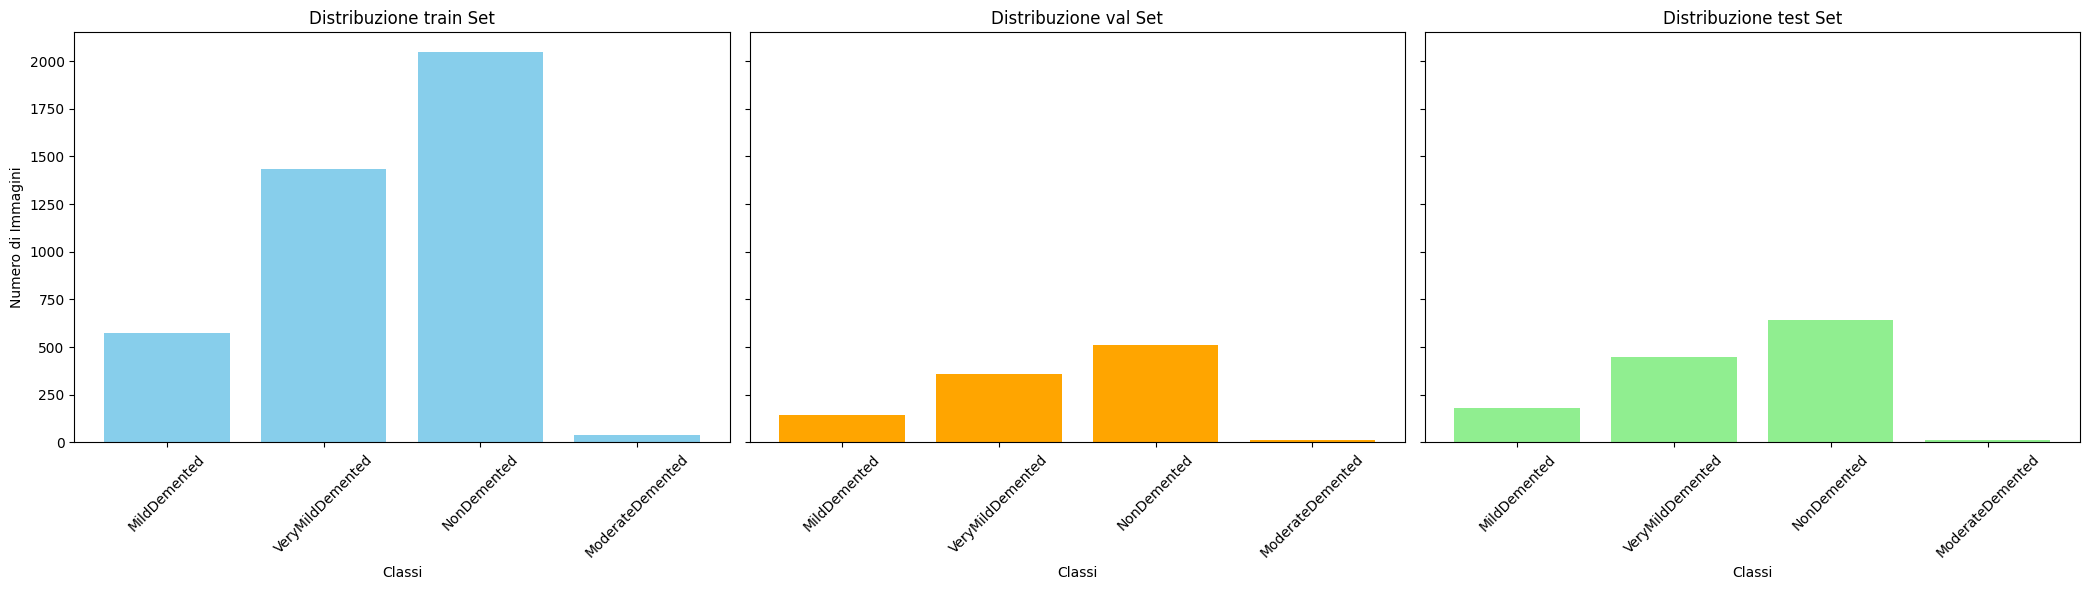

In [8]:
new_train_path = os.path.join(DIR_WORK, 'train')
val_path = os.path.join(DIR_WORK, 'val')
test_path = os.path.join(DIR_WORK, 'test')

new_train_counts = count_images_in_dir(new_train_path)
val_counts = count_images_in_dir(val_path)
test_counts = count_images_in_dir(test_path)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21, 6), sharey=True)

axes[0].bar(new_train_counts.keys(), new_train_counts.values(), color='skyblue')
axes[0].set_title('Distribuzione train Set')
axes[0].set_xlabel('Classi')
axes[0].set_ylabel('Numero di Immagini')
axes[0].set_xticklabels(new_train_counts.keys(), rotation=45)

axes[1].bar(val_counts.keys(), val_counts.values(), color='orange')
axes[1].set_title('Distribuzione val Set')
axes[1].set_xlabel('Classi')
axes[1].set_xticklabels(val_counts.keys(), rotation=45)

axes[2].bar(test_counts.keys(), test_counts.values(), color='lightgreen')
axes[2].set_title('Distribuzione test Set')
axes[2].set_xlabel('Classi')
axes[2].set_xticklabels(test_counts.keys(), rotation=45)

plt.tight_layout()
plt.show()

## Metodi di Data Augmentation: SMOTE e RandAugment

Con SMOTE, andremo a generare nuovi sample per uniformare la distribuzione del dataset di addestramento, il quale è molto sbilanciato. Con RandAugment inoltre andiamo ad applicare un augmentation casuale sui dati per ridurre l'overfitting il più possibile.

In [9]:
# Funzione per preprocessare immagini
def load_and_preprocess_images(directory, target_size=(176, 208)):
    images = []
    labels = []
    class_names = os.listdir(directory)
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                image = img_to_array(load_img(file_path, target_size=target_size))
                images.append(image)
                labels.append(label)
    images = np.array(images, dtype='float32') / 255.0
    labels = np.array(labels)
    return images, labels, class_names

train_images, train_labels, class_names = load_and_preprocess_images(DIR_TRAIN)

In [10]:
# Preprocessing per SMOTE
n_samples, h, w, c = train_images.shape
train_images_flat = train_images.reshape((n_samples, h * w * c))

# Applichiamo Smote
smote = SMOTE(random_state=SEED)
train_images_resampled, train_labels_resampled = smote.fit_resample(train_images_flat, train_labels)

# Eseguiamo un reshape delle immagini per farle tornare come prima
train_images_resampled = train_images_resampled.reshape((-1, h, w, c))


In [11]:
# Funzione per salvare le immagini
def save_resampled_images(images, labels, output_dir, class_names):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for idx, (image, label) in enumerate(zip(images, labels)):
        class_dir = os.path.join(output_dir, class_names[label])
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)
        file_path = os.path.join(class_dir, f"{idx}.jpg")
        cv2.imwrite(file_path, image * 255)


new_train_dir = os.path.join(DIR_WORK, 'new_train')
save_resampled_images(train_images_resampled, train_labels_resampled, new_train_dir, class_names)

In [12]:
# Funzione per visualizzare le immagini
def display_images(dataset, title):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(int(labels[i]))
            plt.axis("off")
    plt.suptitle(title)
    plt.show()

Found 8192 files belonging to 4 classes.
Found 1026 files belonging to 4 classes.
Found 1279 files belonging to 4 classes.


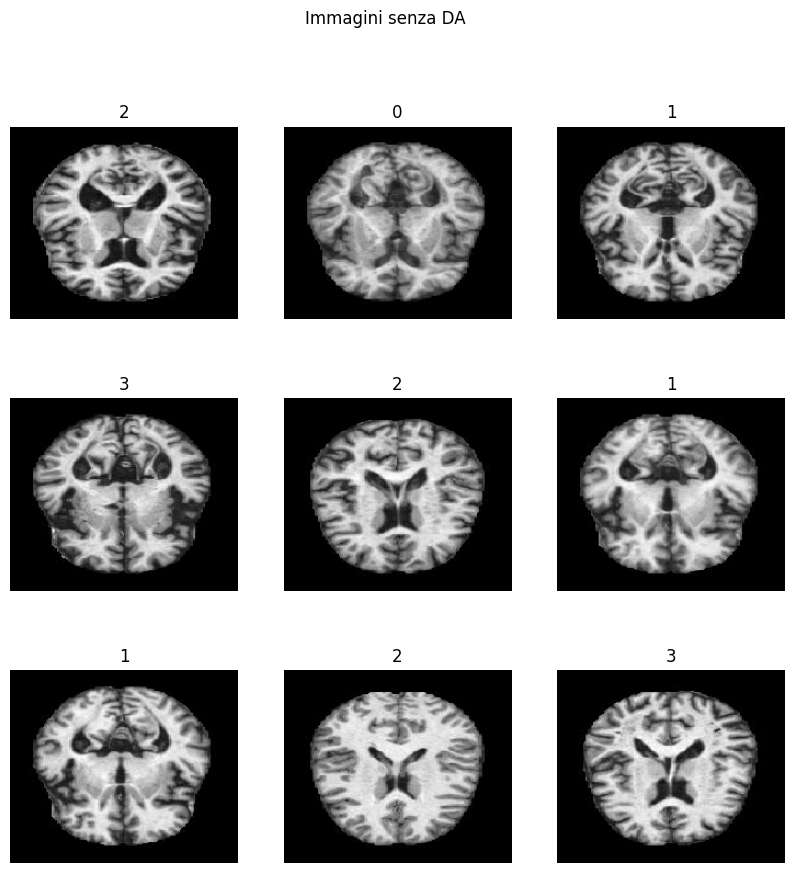

In [13]:
train_dataset = image_dataset_from_directory(
    new_train_dir,
    image_size=(176, 208),
    batch_size=16,
    label_mode='int'
)

val_dataset = image_dataset_from_directory(
    DIR_VAL,
    image_size=(176, 208),
    batch_size=16,
    label_mode='int'
)

test_dataset = image_dataset_from_directory(
    DIR_TEST,
    image_size=(176, 208),
    batch_size=16,
    label_mode='int'
)


display_images(train_dataset, "Immagini senza DA")

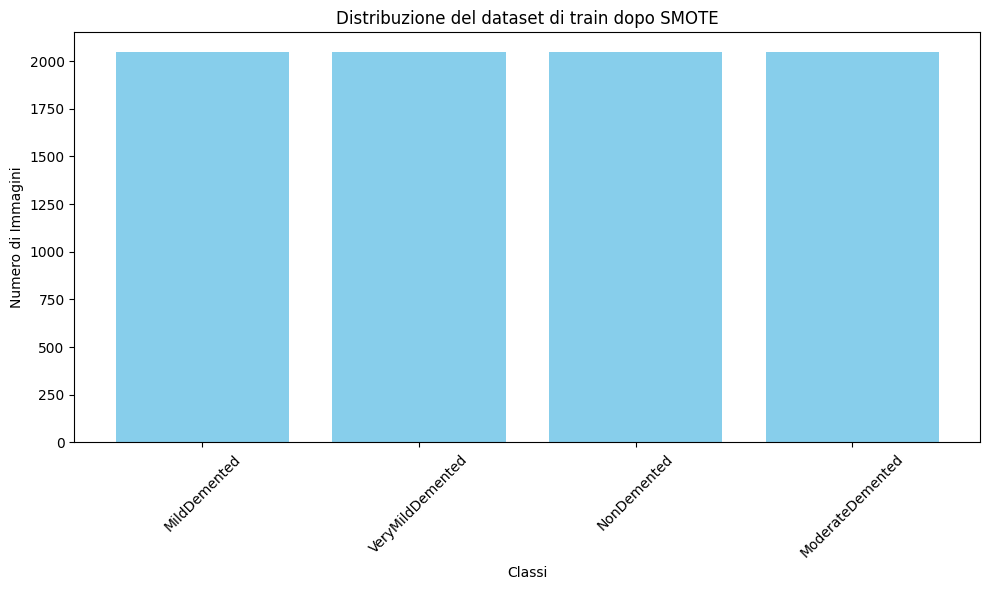

In [15]:
# Ricaviamoci la nuova distribuzione
new_train_counts_resampled = dict(Counter(train_labels_resampled))

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(new_train_counts_resampled.keys(), new_train_counts_resampled.values(), color='skyblue')
ax.set_title('Distribuzione del dataset di train dopo SMOTE')
ax.set_xlabel('Classi')
ax.set_ylabel('Numero di Immagini')
ax.set_xticks(list(new_train_counts_resampled.keys()))
ax.set_xticklabels(class_names, rotation=45)
plt.tight_layout()
plt.show()


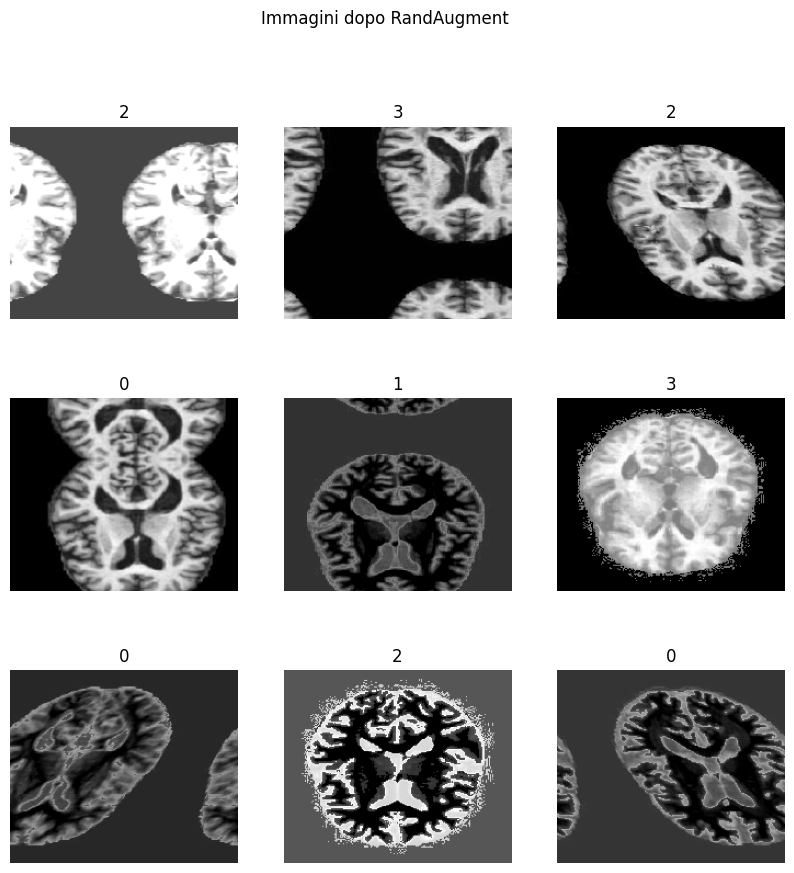

In [16]:
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255), augmentations_per_image=3,
    magnitude=0.4,
    geometric=True
)

# Funzione per applicare RandAugment
def augment(images, labels):
    images = rand_augment(images)
    return images, labels

augmented_train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

display_images(augmented_train_dataset, "Immagini dopo RandAugment")

## Definizione del modello e Addestramento

Utilizzando un modello di base EfficientNetB0, creiamo un architettura sequenziale inserendo un layer di pooling e dei layer densi, intervallati da layer di dropout. Definiamo inoltre una learning rate schedule e un ottimizzatore.

In [17]:
base_model = EfficientNetB0(input_shape=(176, 208, 3),
                      include_top=False,
                      weights="imagenet")

base_model.trainable = True

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
              0.001,
              decay_steps=16*1000,
              decay_rate=1,
              staircase=False)

optimizer = keras.optimizers.Adam(
    learning_rate=lr_schedule,
)

model = models.Sequential([
    layers.Input(shape=(176, 208, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4, activation='softmax')
])

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.build()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 6, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,870,183 (18.58 MB)

 Trainable params: 4,828,160 (18.42 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [19]:
history = model.fit(augmented_train_dataset,
                    epochs=100,
                    validation_data=val_dataset)

loss, accuracy = model.evaluate(test_dataset)
print(f'Test accuracy: {accuracy:.2f}')

Epoch 1/100
512/512 ━━━━━━━━━━━━━━━━━━━━ 258s 252ms/step - accuracy: 0.4364 - loss: 1.1782 - val_accuracy: 0.5906 - val_loss: 0.8602
Epoch 2/100
512/512 ━━━━━━━━━━━━━━━━━━━━ 118s 229ms/step - accuracy: 0.6424 - loss: 0.7908 - val_accuracy: 0.6452 - val_loss: 0.7562
Epoch 3/100
512/512 ━━━━━━━━━━━━━━━━━━━━ 116s 224ms/step - accuracy: 0.6878 - loss: 0.7025 - val_accuracy: 0.5926 - val_loss: 0.9349
Epoch 4/100
512/512 ━━━━━━━━━━━━━━━━━━━━ 122s 235ms/step - accuracy: 0.7206 - loss: 0.6409 - val_accuracy: 0.5809 - val_loss: 1.0470
Epoch 5/100
512/512 ━━━━━━━━━━━━━━━━━━━━ 116s 225ms/step - accuracy: 0.7605 - loss: 0.5668 - val_accuracy: 0.7729 - val_loss: 0.5394
Epoch 6/100
512/512 ━━━━━━━━━━━━━━━━━━━━ 146s 232ms/step - accuracy: 0.7746 - loss: 0.5277 - val_accuracy: 0.7641 - val_loss: 0.5457
Epoch 7/100
512/512 ━━━━━━━━━━━━━━━━━━━━ 142s 232ms/step - accuracy: 0.7911 - loss: 0.4954 - val_accuracy: 0.8021 - val_loss: 0.4731
Epoch 8/100
512/512 ━━━━━━━━━━━━━━━━━━━━ 121s 234ms/step - accuracy: 

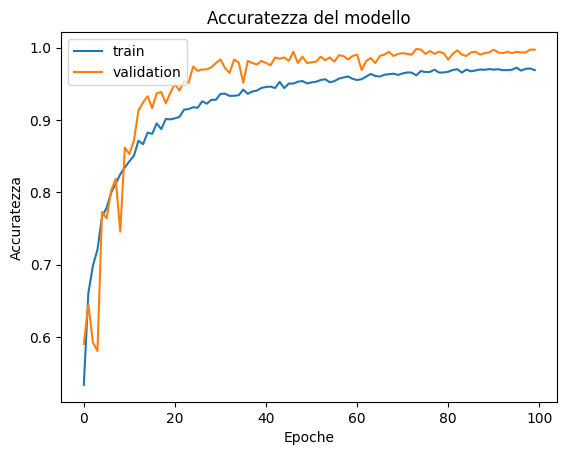

In [20]:
# Plottiamo l'andamento del processo di training
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuratezza del modello")
plt.ylabel("Accuratezza")
plt.xlabel("Epoche")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

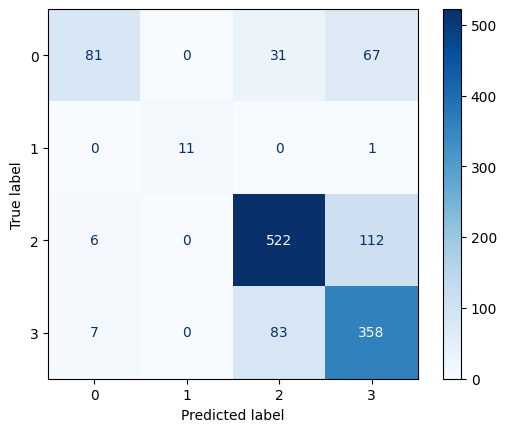

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
true_labels = []
pred_labels = []

for images, labels in test_dataset:
    predictions = model.predict(images, verbose=False)
    predicted_labels = np.argmax(predictions, axis=1)

    true_labels.extend(labels.numpy())
    pred_labels.extend(predicted_labels)

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Calcola la matrice di confusione
cm = confusion_matrix(true_labels, pred_labels)

# Visualizza la matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [38]:
from sklearn.metrics import classification_report
import pandas as pd

# Calcola il report di classificazione
report = classification_report(true_labels, pred_labels, target_names=test_dataset.class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()
# Visualizza il DataFrame
print(report_df)



                  precision    recall  f1-score      support
MildDemented       0.861702  0.452514  0.593407   179.000000
ModerateDemented   1.000000  0.916667  0.956522    12.000000
NonDemented        0.820755  0.815625  0.818182   640.000000
VeryMildDemented   0.665428  0.799107  0.726166   448.000000
accuracy           0.759969  0.759969  0.759969     0.759969
macro avg          0.836971  0.745978  0.773569  1279.000000
weighted avg       0.773760  0.759969  0.755791  1279.000000
